In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from tqdm import tqdm

2024-12-04 15:49:25.399719: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def myq(X, y, w):
    d = np.size(X, axis=1)
    d2 = d * d

    W = np.reshape(w[:d2], (d, d))
    v = w[d2 : d2 + d]
    b = w[-1]

    qterm = np.diag(X @ W @ np.transpose(X))
    return y * qterm + (np.outer(y, np.ones((d,))) * X) @ v + y * b

def f(X, y, w, lambd):
  q = myq(X, y, w)
  summand = np.log(1 + np.exp(-q))
  return np.mean(summand) + lambd / 2 * np.linalg.norm(w)**2

def grad_f(X, y, w, lambd):
  n, d = X.shape
  d2 = d * d

  W = np.reshape(w[:d2], (d, d))
  v = w[d2 : d2 + d]
  b = w[-1]

  sum_grad = np.zeros_like(w)
  for j in range(n):
    grad_W = y[j] * np.outer(X[j], X[j])
    grad_v = y[j] * X[j]
    grad_b = y[j]

    grad_q = np.zeros(d2 + d + 1)
    grad_q[:d2] = np.reshape(grad_W, (d2,))
    grad_q[d2 : d2 + d] = grad_v
    grad_q[-1] = grad_b

    q = y[j] * (np.inner(X[j], W @ X[j]) + np.inner(v, X[j]) + b)
    sum_grad += grad_q / (1 + np.exp(q))
  return -sum_grad / n + lambd * w

In [3]:
def plot_convergence(loss, norm_grad_loss):
  fig, (ax1, ax2) = plt.subplots(2, 1)

  ax1.plot(loss)
  ax1.set_xlabel('$k$')
  ax1.set_ylabel('$f$')
  ax1.set_yscale('log')

  ax2.plot(norm_grad_loss)
  ax2.set_xlabel('$k$')
  ax2.set_ylabel('$||\\nabla f||$')
  ax2.set_yscale('log')

  plt.tight_layout()
  plt.show()

In [4]:
# Load and preprocess the MNIST data
def load_mnist(npcas=None):
  (imgs_train, labels_train), (imgs_test, labels_test) = mnist.load_data()
  imgs_train = imgs_train.reshape((60000, 784))
  imgs_test = imgs_test.reshape((10000, 784))

  imgs_train_1 = imgs_train[labels_train == 1, :]
  imgs_train_7 = imgs_train[labels_train == 7, :]
  imgs_test_1 = imgs_test[labels_test == 1, :]
  imgs_test_7 = imgs_test[labels_test == 7, :]

  imgs_train = np.concatenate((imgs_train_1, imgs_train_7), axis=0)
  imgs_test = np.concatenate((imgs_test_1, imgs_test_7), axis=0)

  labels_train = np.ones(len(imgs_train))
  labels_train[len(imgs_train_1):] = -1
  labels_test = np.ones(len(imgs_test))
  labels_test[len(imgs_test_1):] = -1

  if npcas:
    U, S, Vtrans = np.linalg.svd(imgs_train, full_matrices=False)
    V = np.transpose(Vtrans)
    imgs_train = imgs_train @ V[:, :npcas]
    imgs_test = imgs_test @ V[:, :npcas]

  return imgs_train, imgs_test, labels_train, labels_test

In [5]:
# X_train, X_test, lbl_train, lbl_test = load_mnist(npcas=20)

import scipy.io

# Read mnist data from the mat file
mnist_data = scipy.io.loadmat("mnist2.mat")
imgs_train = mnist_data['imgs_train']
imgs_test = mnist_data['imgs_test']
labels_train = np.squeeze(mnist_data['labels_train'])
labels_test = np.squeeze(mnist_data['labels_test'])

d1,d2,N = np.shape(imgs_train)
dd = d1 * d2

# Select images of 1 and 7
Itrain_1 = np.where(labels_train == 1)
Itrain_7 = np.where(labels_train == 7)
Itest_1 = np.where(labels_test == 1)
Itest_7 = np.where(labels_test == 7)
imgs_train_1 = np.squeeze(imgs_train[:,:,Itrain_1])
imgs_train_7 = np.squeeze(imgs_train[:,:,Itrain_7])
imgs_test_1 = np.squeeze(imgs_test[:,:,Itest_1])
imgs_test_7 = np.squeeze(imgs_test[:,:,Itest_7])
Ntrain_1 = np.size(Itrain_1)
Ntrain_7 = np.size(Itrain_7)
Ntest_1 = np.size(Itest_1)
Ntest_7 = np.size(Itest_7)

# Prepare the train set
X1_train = np.zeros((Ntrain_1, dd))
for j in range(Ntrain_1):
    img = np.squeeze(imgs_train_1[:, :, j])
    X1_train[j, :] = np.reshape(img, (dd,))
X7_train = np.zeros((Ntrain_7, dd))
for j in range(Ntrain_7):
    img = np.squeeze(imgs_train_7[:, :, j])
    X7_train[j, :] = np.reshape(img, (dd,))
X_train = np.concatenate((X1_train, X7_train), axis=0)
print(f"X_train: {np.shape(X_train)}")
U, S, Vtrans = np.linalg.svd(X_train, full_matrices=False)
print(f"U: {np.shape(U)}; S: {np.shape(S)}; V_trans: {np.shape(Vtrans)}")
V = np.transpose(Vtrans)

# Prepare the test set
X1_test = np.zeros((Ntest_1, dd))
for j in range(Ntest_1):
    img = np.squeeze(imgs_test_1[:, :, j])
    X1_test[j, :] = np.reshape(img, (dd,))
X7_test = np.zeros((Ntest_7, dd))
for j in range(Ntest_7):
    img = np.squeeze(imgs_test_7[:, :, j])
    X7_test[j, :] = np.reshape(img, (dd,))
X_test = np.concatenate((X1_test, X7_test), axis=0)

# prepare labels for the train and test sets: ones have label 1, sevens have label -1
Ntrain = Ntrain_1 + Ntrain_7
Ntest = Ntest_1 + Ntest_7
lbl_train = np.ones((Ntrain,))
lbl_train[Ntrain_1:] = -1
lbl_test = np.ones((Ntest,))
lbl_test[Ntest_1:] = -1

d = 20

X_train = X_train @ V[:, :d]
X_test = X_test @ V[:, :d]

X_train: (13007, 400)
U: (13007, 400); S: (400,); V_trans: (400, 400)


In [6]:
def myloss(w):
  return f(X_train, lbl_train, w, 1e-4)

def mygrad(w):
  return grad_f(X_train, lbl_train, w, 1e-4)

### 1. (a) Deterministic & Stochastic Nesterov

In [7]:
# Nesterov's accelerated gradient descent w/ constant step size alpha
def nesterov(loss, grad, x, iters, alpha):
  v = np.zeros_like(x)
  losses = []
  grad_norms = []

  for k in tqdm(range(iters)):
    mu = 1 - 3 / (5 + k)
    v = mu * v - alpha * grad(x + mu * v)
    x = x + v

    losses.append(loss(x))
    grad_norms.append(np.linalg.norm(grad(x)))
  return x, losses, grad_norms

100%|██████████| 150/150 [02:52<00:00,  1.15s/it]


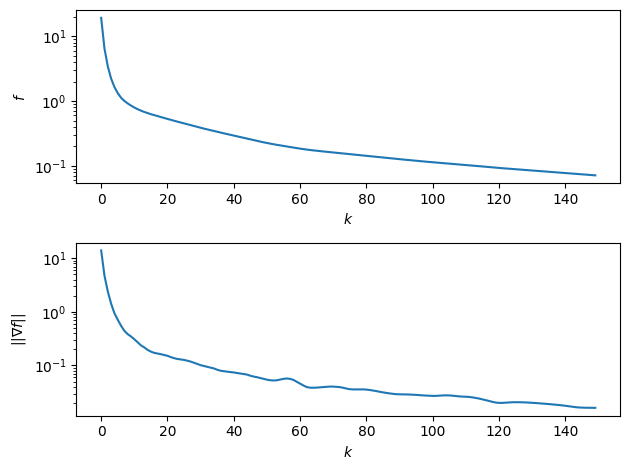

19


In [8]:
d = 20
w = np.ones(d * d + d + 1)
w, losses, grad_norms = nesterov(myloss, mygrad, w, 150, 1e-1)
plot_convergence(losses, grad_norms)

test = myq(X_test, lbl_test, w)
misses = np.argwhere(test < 0)
print(len(misses))

In [9]:
def stochastic_nesterov():
  return

### 1. (b) Deterministic & Stochastic Adam

In [10]:
# Adam as described in its original paper (https://arxiv.org/pdf/1412.6980)
def adam(loss, grad, theta, iters, alpha=1e-1, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
  m = np.zeros_like(theta)
  v = np.zeros_like(theta)
  losses = []
  grad_norms = []

  for t in tqdm(range(1, iters)):
    g = grad(theta)
    m = beta_1 * m + (1 - beta_1) * g
    v = beta_2 * v + (1 - beta_2) * g**2
    m_hat = m / (1 - beta_1**t)
    v_hat = v / (1 - beta_2**t)
    theta = theta - alpha * m_hat / (np.sqrt(v_hat) + epsilon)

    losses.append(loss(theta))
    grad_norms.append(np.linalg.norm(grad(theta)))
  return theta, losses, grad_norms

100%|██████████| 49/49 [00:59<00:00,  1.21s/it]


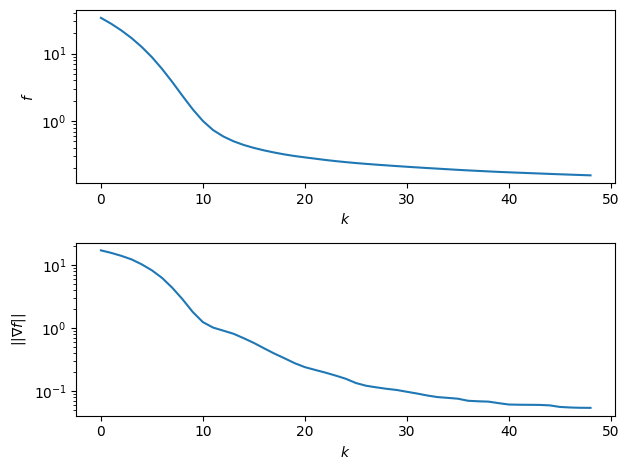

17


In [11]:
d = 20
w = np.ones(d * d + d + 1)
w, losses, grad_norms = adam(myloss, mygrad, w, 50)
plot_convergence(losses, grad_norms)

test = myq(X_test, lbl_test, w)
misses = np.argwhere(test < 0)
print(len(misses))

In [12]:
def stochastic_adam():
  return

### 4. Quadratic Program

In [13]:
def plot_feasible(obj, constrs, min_global, iters):
  s = np.linspace(-2, 5, 1000)
  X, Y = np.meshgrid(s, s)

  plt.contour(X, Y, obj(X, Y), colors='k')
  plt.contour(X, Y, constrs(X, Y))
  plt.scatter(min_global[0], min_global[1], c='r', marker='*')
  plt.plot(iters[0], iters[1], c='b', marker='*', zorder=2)

  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.gca().set_aspect('equal', adjustable='box')
  plt.show()

In [14]:
def objective(x, y):
  return (x - 1)**2 + (y - 2.5)**2

def constraints(x, y):
  return (x - 2*y + 2 >= 0) & (-x - 2*y + 6 >= 0) & (-x + 2*y + 2 >= 0) & (x >= 0) & (y >= 0)

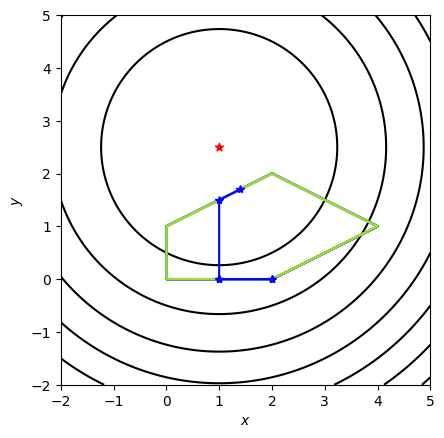

In [15]:
plot_feasible(objective, constraints, [1, 5 / 2], [[2, 2, 1, 1, 1, 7 / 5], [0, 0, 0, 0, 3 / 2, 17 / 10]])